<a href="https://colab.research.google.com/github/MeidanGR/SpeechEmotionRecognition_Realtime/blob/main/3_realtime_ser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
%%capture
%pip install pydub
%pip install noisereduce
%pip install pyaudio
%pip install json-tricks
%pip install torch

In [68]:
%%capture
import os
from json_tricks import load

import numpy as np

import librosa
from pydub import AudioSegment, effects
import noisereduce as nr

import tensorflow as tf
import keras
from keras.models import model_from_json
from keras.models import load_model

import matplotlib.pyplot as plt

# **LOAD MODEL**
Loading the speech emotion recognition LSTM model and weights.

In [69]:
saved_model_path = './model8723.json'
saved_weights_path = './model8723_weights.h5'

#Reading the model from JSON file
with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 339, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54024 (211.03 KB)
Trainable params: 54024 (211.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [70]:
def preprocess(file_path, frame_length = 2048, hop_length = 512):
    '''
    A process to an audio .wav file before execcuting a prediction.
      Arguments:
      - file_path - The system path to the audio file.
      - frame_length - Length of the frame over which to compute the speech features. default: 2048
      - hop_length - Number of samples to advance for each frame. default: 512

      Return:
        'X_3D' variable, containing a shape of: (batch, timesteps, feature) for a single file (batch = 1).
    ''' 
    # Fetch sample rate.
    _, sr = librosa.load(path = file_path, sr = None)
    # Load audio file
    rawsound = AudioSegment.from_file(file_path, duration = None) 
    # Normalize to 5 dBFS 
    normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
    # Transform the audio file to np.array of samples
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32') 
    # Noise reduction                  
    final_x = nr.reduce_noise(normal_x, sr=sr)
        
        
    f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length, center=True, pad_mode='reflect').T # Energy - Root Mean Square
    f2 = librosa.feature.zero_crossing_rate(final_x, frame_length=frame_length, hop_length=hop_length,center=True).T # ZCR
    f3 = librosa.feature.mfcc(y=final_x, sr=sr, S=None, n_mfcc=13, hop_length = hop_length).T # MFCC   
    X = np.concatenate((f1, f2, f3), axis = 1)
    
    X_3D = np.expand_dims(X, axis=0)
    
    return X_3D

In [71]:
# Emotions list is created for a readable form of the model prediction.

emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'   
}
emo_list = list(emotions.values())

def is_silent(data):
    # Returns 'True' if below the 'silent' threshold
    return max(data) < 100


** session started
* recording...
* done recording
{'outputs': [[0.205854356, 0.029721655, 4.67260634e-07, 0.000469475519, 6.69132078e-06, 0.000482435105, 0.215462863, 0.548001945]]}


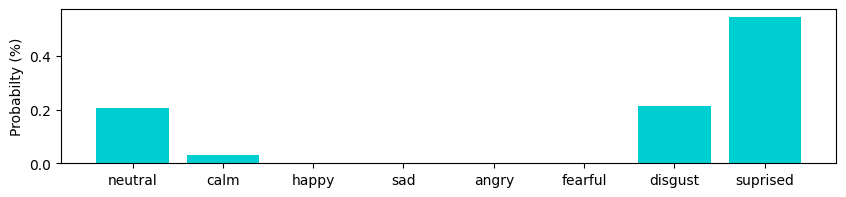

max emotion: suprised
----------------------------------------------------------------------------------------------------
* recording...


/tmp/ipykernel_23294/4055973378.py:86: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 153 to int8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  last_frames = np.array(struct.unpack(str(96 * CHUNK) + 'B' , np.stack(( frames[-1], frames[-2], frames[-3], frames[-4],
/tmp/ipykernel_23294/4055973378.py:86: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 253 to int8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  last_frames = np.array(struct.unpack(str(96 * CHUNK) + 'B' , np.stack(( frames[-1], frames[-2], frames[-3], frames[-4],
/tmp/ipykernel_23294/4055973378.py:86: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python 

KeyboardInterrupt: 

In [72]:
import pyaudio
import wave
from array import array
import struct
import time
import requests
import json

# Initialize variables
RATE = 24414
CHUNK = 512
RECORD_SECONDS = 7.1

FORMAT = pyaudio.paInt32
CHANNELS = 1
WAVE_OUTPUT_FILE = "./output.wav"

# Open an input channel
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)


# Initialize a non-silent signals array to state "True" in the first 'while' iteration.
data = array('h', np.random.randint(size = 512, low = 0, high = 500))

# SESSION START
print("** session started")
total_predictions = [] # A list for all predictions in the session.
tic = time.perf_counter()

while is_silent(data) == False:
    print("* recording...")
    frames = [] 
    data = np.nan # Reset 'data' variable.

    timesteps = int(RATE / CHUNK * RECORD_SECONDS) # => 339

    # Insert frames to 'output.wav'.
    for i in range(0, timesteps):
        data = array('l', stream.read(CHUNK)) 
        frames.append(data)

        wf = wave.open(WAVE_OUTPUT_FILE, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))

    print("* done recording")

    x = preprocess(WAVE_OUTPUT_FILE) # 'output.wav' file preprocessing.
    # Model's prediction => an 8 emotion probabilities array.
    #make http request to predict model at port 8051
   
    url = 'http://localhost:8501/v1/models/fashion_model:predict'
    headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}
    r = requests.post(url, data=json.dumps({"inputs":{"lstm_input": x.tolist()}}), headers=headers)
    if(r.status_code != 200):
        print("error")
        break
    result = r.json()
    print(result)
    predictions = np.array(result['outputs'])

    # predictions = model.predict(x, use_multiprocessing=True)
    pred_list = list(predictions)
    pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0) # Get rid of 'array' & 'dtype' statments.
    total_predictions.append(pred_np)
    
    # Present emotion distribution for a sequence (7.1 secs).
    fig = plt.figure(figsize = (10, 2))
    plt.bar(emo_list, pred_np, color = 'darkturquoise')
    plt.ylabel("Probabilty (%)")
    plt.show()
    
    max_emo = np.argmax(predictions)
    print('max emotion:', emotions.get(max_emo,-1))
    
    print(100*'-')
    
    # Define the last 2 seconds sequence.
    last_frames = np.array(struct.unpack(str(96 * CHUNK) + 'B' , np.stack(( frames[-1], frames[-2], frames[-3], frames[-4],
                                                                            frames[-5], frames[-6], frames[-7], frames[-8],
                                                                            frames[-9], frames[-10], frames[-11], frames[-12],
                                                                            frames[-13], frames[-14], frames[-15], frames[-16],
                                                                            frames[-17], frames[-18], frames[-19], frames[-20],
                                                                            frames[-21], frames[-22], frames[-23], frames[-24]),
                                                                            axis =0)) , dtype = 'b')
    if is_silent(last_frames): # If the last 2 seconds are silent, end the session.
        break

# SESSION END        
toc = time.perf_counter()
stream.stop_stream()
stream.close()
p.terminate()
wf.close()
print('** session ended')

# Present emotion distribution for the whole session.
total_predictions_np =  np.mean(np.array(total_predictions).tolist(), axis=0)
fig = plt.figure(figsize = (10, 5))
plt.bar(emo_list, total_predictions_np, color = 'indigo')
plt.ylabel("Mean probabilty (%)")
plt.title("Session Summary")
plt.show()

print(f"Emotions analyzed for: {(toc - tic):0.4f} seconds")